In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Param

In [3]:
data_dir = 'dataset/edge_detection'
classes = ['1000', '2000', '5000', '10000', '20000', '50000', '100000']
IMG_SIZE = (256,256)

EPOCHS = 50
BATCH_SIZE = 32
K = 200

# Preprocessing

In [50]:
raw_dir = 'dataset/raw'

# Create output directory structure
Path(data_dir).mkdir(parents=True, exist_ok=True)
for cls in classes:
    Path(os.path.join(data_dir, cls)).mkdir(parents=True, exist_ok=True)

def apply_edge_detection(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    sobel_x = cv2.Sobel(blurred, cv2.CV_64F, dx=1, dy=0, ksize=3)  # x
    sobel_y = cv2.Sobel(blurred, cv2.CV_64F, dx=0, dy=1, ksize=3)  # y
    
    # Combine the two gradients
    edge = cv2.magnitude(sobel_x, sobel_y)
    return edge

# Loop through each class
for cls in classes:
    raw_class_dir = os.path.join(raw_dir, cls)
    output_class_dir = os.path.join(data_dir, cls)
    
    # Process each image in the class folder
    for img_name in tqdm(os.listdir(raw_class_dir), desc=f'Processing {cls}'):
        img_path = os.path.join(raw_class_dir, img_name)
        
        # Read the image
        image = cv2.imread(img_path)

        # Apply edge detection
        edges = apply_edge_detection(image)

        # Save the processed image to the edge_detection directory
        output_img_path = os.path.join(output_class_dir, img_name)
        cv2.imwrite(output_img_path, edges)

print("Edge detection preprocessing completed.")

Processing 100000: 100%|██████████| 128/128 [00:24<00:00,  5.27it/s]

Edge detection preprocessing completed.


# Feature Extraction (SIFT, ORB -> Bag of Visual Words)

In [17]:
def modelEvaluation(history):    
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

def extract_features(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, IMG_SIZE)
    
    sift = cv2.SIFT_create()
    orb = cv2.ORB_create()

    sift_keypoints, sift_descriptors = sift.detectAndCompute(image, None)
    orb_keypoints, orb_descriptors = orb.detectAndCompute(image, None)

    return sift_descriptors, orb_descriptors

# Build the vocabulary_sift for BOVW using K-means clustering
def build_vocabulary_sift(descriptors_list, k=K):
    # Stack all descriptors together for K-means
    all_descriptors = np.vstack(descriptors_list)
    
    # Perform K-means clustering to form the visual vocabulary_sift using sklearn's KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_descriptors)
    
    return kmeans

def compute_bovw_histogram(descriptors, kmeans):
    # Assign each descriptor to the nearest visual word (cluster center)
    words = kmeans.predict(descriptors)
    
    # Create a histogram of visual words
    histogram = np.zeros(kmeans.cluster_centers_.shape[0])
    for word in words:
        histogram[word] += 1
    
    return histogram

# Function to load dataset and compute BOVW for each image
def load_dataset(kmeans_sift=None, kmeans_orb=None):
    x_sift = []
    y_sift = []
    x_orb = []
    y_orb = []
    
    sift_descriptors_list = []
    orb_descriptors_list = []
    
    for label, cls in enumerate(classes):
        cls_dir = os.path.join(data_dir, cls)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            sift_descriptors, orb_descriptors = extract_features(img_path)
            
            if sift_descriptors is not None:
                sift_descriptors_list.append(sift_descriptors)
            if orb_descriptors is not None:
                orb_descriptors_list.append(orb_descriptors)
    
    if kmeans_sift is None:
        kmeans_sift = build_vocabulary_sift(sift_descriptors_list)
        joblib.dump(kmeans_sift, 'sift_kmeans.pkl')
    if kmeans_orb is None:
        kmeans_orb = build_vocabulary_sift(orb_descriptors_list)
        joblib.dump(kmeans_orb, 'orb_kmeans.pkl')
    
    # Extract BOVW histograms for each image
    for label, cls in enumerate(classes):
        cls_dir = os.path.join(data_dir, cls)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            sift_descriptors, orb_descriptors = extract_features(img_path)
            
            if sift_descriptors is not None:
                # Convert the descriptors to BOVW histogram
                sift_histogram = compute_bovw_histogram(sift_descriptors, kmeans_sift)
                x_sift.append(sift_histogram)
                y_sift.append(label)

            if orb_descriptors is not None:
                orb_histogram = compute_bovw_histogram(orb_descriptors, kmeans_orb)
                x_orb.append(orb_histogram)
                y_orb.append(label)
    
    x_sift = np.array(x_sift)
    y_sift = np.array(y_sift)
    x_orb = np.array(x_orb)
    y_orb = np.array(y_orb)

    # Normalize
    sift_scaler = StandardScaler()
    orb_scaler = StandardScaler()
    x_sift = sift_scaler.fit_transform(x_sift)
    x_orb = orb_scaler.fit_transform(x_orb)

    # Save scaler
    joblib.dump(sift_scaler, 'sift_scaler.pkl')
    joblib.dump(orb_scaler, 'orb_scaler.pkl')

    return x_sift, y_sift, x_orb, y_orb

In [7]:
x, y, x_orb, y_orb = load_dataset()
print(f'{x.shape} | {x_orb.shape}')

(900, 200) | (903, 200)


# SIFT -> MLP

In [8]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp,y_temp, test_size=0.5, random_state=42)

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)

In [9]:
model_sift = Sequential([
    Dense(256, activation='relu', input_dim=x_train.shape[1], kernel_regularizer=l2(0.0001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])
model_sift.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_sift.summary()


c:\Users\kodya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,255 (333.03 KB)

 Trainable params: 85,255 (333.03 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history_sift = model_sift.fit(
    x_train, 
    y_train, 
    validation_data=(x_test, y_test), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1664 - loss: 2.4769 - val_accuracy: 0.3889 - val_loss: 1.7099
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2903 - loss: 1.8563 - val_accuracy: 0.5000 - val_loss: 1.5304
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4022 - loss: 1.6392 - val_accuracy: 0.5000 - val_loss: 1.4440
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4240 - loss: 1.4815 - val_accuracy: 0.5333 - val_loss: 1.3801
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4784 - loss: 1.3785 - val_accuracy: 0.5889 - val_loss: 1.3090
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4791 - loss: 1.3559 - val_accuracy: 0.5889 - val_loss: 1.2683
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5364 - loss: 1.2269 - val_accuracy: 0.5889 - val_loss: 1.2234
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6026 - loss: 1.0990 - val_accuracy: 0.6222 - val_loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7100 - loss: 1.3804 
Validation Loss: 1.4887654781341553
Validation Accuracy: 0.6777777671813965


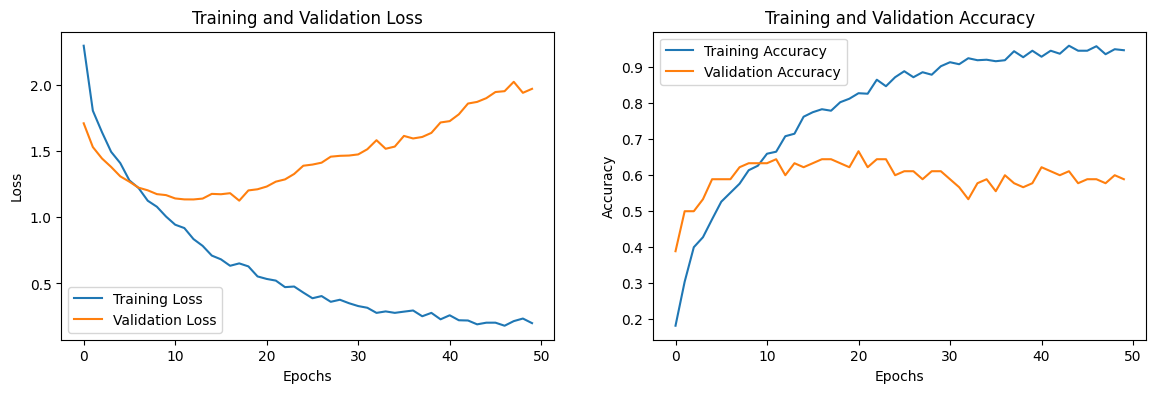

In [11]:
val_loss, val_accuracy = model_sift.evaluate(x_val, y_val)

print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

modelEvaluation(history_sift)

# ORB -> MLP

In [12]:
x_train, x_temp, y_train, y_temp = train_test_split(x_orb, y_orb, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp,y_temp, test_size=0.5, random_state=42)

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)


In [13]:
model_orb = Sequential([
    Dense(256, activation='relu', input_dim=x_train.shape[1], kernel_regularizer=l2(0.0001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model_orb.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_orb.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,255 (333.03 KB)

 Trainable params: 85,255 (333.03 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history_orb = model_orb.fit(
    x_train, 
    y_train, 
    validation_data=(x_test, y_test), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1776 - loss: 2.4887 - val_accuracy: 0.3444 - val_loss: 1.7723
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2649 - loss: 2.0022 - val_accuracy: 0.4333 - val_loss: 1.6665
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3235 - loss: 1.7385 - val_accuracy: 0.4444 - val_loss: 1.5914
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4448 - loss: 1.5651 - val_accuracy: 0.4667 - val_loss: 1.5232
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4819 - loss: 1.4510 - val_accuracy: 0.5000 - val_loss: 1.4585
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4929 - loss: 1.3438 - val_accuracy: 0.5444 - val_loss: 1.4091
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5882 - loss: 1.2291 - val_accuracy: 0.5556 - val_loss: 1.3480
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5713 - loss: 1.1523 - val_accuracy: 0.5556 - val_loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5661 - loss: 1.9372 
Validation Loss: 2.2258427143096924
Validation Accuracy: 0.5384615659713745


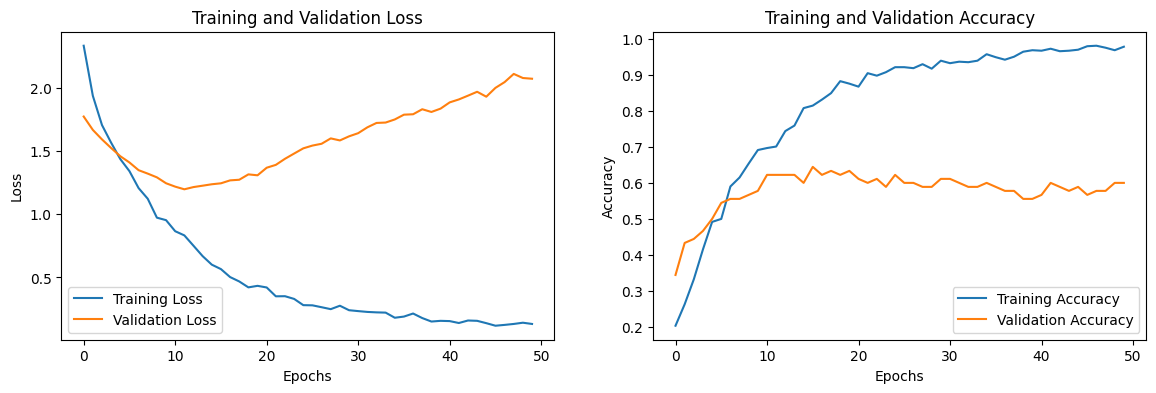

In [15]:
val_loss, val_accuracy = model_orb.evaluate(x_val, y_val)

print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

modelEvaluation(history_orb)

In [16]:
model_sift.save('sift_model.keras')
model_orb.save('orb_model.keras')